# Chainerによるニューラルネットワーク

## 本チュートリアルではchainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます．

Chainerでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．はじめに必要なモジュールを読み込みます．

In [1]:
import numpy as np
import chainer
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

chainerのバージョンを確認します．

In [5]:
chainer.__version__

'4.0.0'

次に学習データを読み込みます．MNISTデータセットはチュートリアルでよく利用されるデータセットであり，chainerではMNISTデータセットを取得し，学習するためのフォーマットに変換してくれます．データセットには学習用とテスト用のデータに分かれており，それぞれtrain_dataset, test_datasetとします．また，それらには画像データと教師ラベルがあり，それらをtrain_xとtrain_y，test_xとtest_yとします．

In [6]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_x,train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

学習データのサイズを確認します．学習データ数は6万枚，１つのデータのサイズは784次元となっています．
また，評価データ数は1万枚となっています．

In [7]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


MNISTデータセットに含まれる画像を表示してみます．ここでは，matplotlibで複数の画像を表示させるプログラムを利用します．

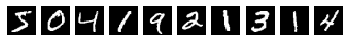

In [9]:
import cv2
import matplotlib.pyplot as plt
import os.path

cols = 10

def clearLabel(_ax):
    _ax.tick_params(labelbottom=False, bottom=False)
    _ax.tick_params(labelleft=False, left=False)
    _ax.set_xticklabels([]) 
    _ax.axis('off')
    return _ax

def readImage(idx):
    bimg = train_x[idx].copy()
    label = train_y[idx]
    bimg = bimg.reshape(28,28)
    return bimg

fig = plt.figure()

for c in range(cols):
    ax1 = fig.add_subplot(1, cols, c+1)
    clearLabel(ax1)
    show_img1 = readImage(c)
    plt.gray()
    plt.imshow(show_img1)

ニューラルネットワークを定義します．ここでは，入力層，中間層，出力層から構成される３層のニューラルネットワークとします．入力層のユニット数は入力データのサイズによります．ここではNoneとし，データにより変更できるようにしておきます．中間層と出力層のユニット数は引数として与え，それぞれn_units，n_outとします． Chainerでは，\__init\__関数にこれらの引数を与えて各層を定義します．各層はlinear関数としています．これは全結合層を意味しています．そして，\__call\__関数で定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したl1という中間層に与え，その出力を活性化関数であるrelu関数に与えます．その出力をh1としています．h1は出力層h2に与えられ，その出力をh2としています．

In [10]:
class NN(chainer.Chain):
    def __init__(self, n_units, n_out):
        super().__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(n_units, n_out),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        return self.l2(h1)

中間層と出力層のユニット数を定義します．ここでは中間層のユニット数を50，出力層のユニット数を10とします．

In [11]:
n_units = 50
out_units = 10

各層のユニット数をNN関数の引数として与え，ネットワークモデルを定義します．学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.01，モーメンタムを0.9として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．

In [12]:
model = NN(n_units, out_units)
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を100とします．

In [13]:
batch_size = 100
epoch_num = 10

MNISTの学習データサイズを取得し，１エポック内における更新回数を求めます．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとします．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [14]:
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
        sum_loss = 0
        sum_accuracy = 0
        perm = np.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(train_x[perm[i:i+batch_size]])
                t = Variable(train_y[perm[i:i+batch_size]])
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data*batch_size
                sum_accuracy += acc.data*batch_size
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1,
                                                                   sum_loss/train_data_num,
                                                                   sum_accuracy/train_data_num))

epoch: 1, mean loss: 0.5017839224636554, mean accuracy: 0.8627000015228987
epoch: 2, mean loss: 0.2657307610909144, mean accuracy: 0.9240500022967656
epoch: 3, mean loss: 0.2194716155032317, mean accuracy: 0.9376000014940897
epoch: 4, mean loss: 0.18811602457736928, mean accuracy: 0.9455333347121875
epoch: 5, mean loss: 0.1639216464323302, mean accuracy: 0.9525333362817764
epoch: 6, mean loss: 0.1446256748214364, mean accuracy: 0.9580166694521904
epoch: 7, mean loss: 0.13079053243311742, mean accuracy: 0.961750005185604
epoch: 8, mean loss: 0.11847388257272541, mean accuracy: 0.9659166712562243
epoch: 9, mean loss: 0.10995933233139416, mean accuracy: 0.9687500067551931
epoch: 10, mean loss: 0.10150001933487753, mean accuracy: 0.9707666754722595


学習できたネットワークモデルを利用して評価を行います．

In [15]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(np.array([test_x[i]], dtype=np.float32))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.9648


## 課題　
### 以下の課題に取り組みましょう

1  ネットワーク構造を変えて実験しましょう． 

   まず，中間層のユニット数を200個にしましょう．
   
   次に，中間層を1層増やしましょう．その際， 中間層のユニット数は200個としましょう．

2  最適化の方法をAdamに変えて実験しましょう．


3  エポック数やミニバッチサイズを変えて実験しましょう．

  まず，ミニバッチサイズを128にしましょう．
  
  次に，エポック数を50にしましょう．

##別のコードの書き方

ここまでのコードは学習の流れをわかりやすくするために，エポックまたはミニバッチ毎にfor文で学習を行うようにプログラムを作成しました． chainerでは，trainerとupdaterという繰り返し処理を抽象化するクラスが用意されています．これらを利用した場合は，以下のように書くことができます．

SerialIteratorにより学習および評価データを繰り返し取得することができます．　StarndardUpdaterは， SerialIteratorによって繰り返し取得したデータをoptimizerに渡してmodelをアップデートします． TrainerはこのUpdaterの処理を指定されたエポック回数分行い，学習したモデルをresultに保存できます． Trainerにはさまざなま拡張機能を追加できます．Evaluatorは学習したモデルを評価する機能であり，LogReportは学習時のロスは精度を記憶します．これらの記憶されているログをPlotReportが表示したりグラフとして保存したりします．　学習の実行はtrainerクラスのrun関数により行います．

In [16]:
from chainer import training
from chainer.training import extensions

batch_size = 100
epoch_num = 10

n_units = 50
out_units = 10

model = L.Classifier(NN(n_units, out_units))
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size, repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                                     'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy','validation/main/accuracy'],
                                     'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch',
                                       'main/loss',
                                       'validation/main/loss',
                                       'main/accuracy',
                                       'validation/main/accuracy',
                                       'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.490219    0.28501               0.864033       0.9183                    1.42788       
2           0.26413     0.230675              0.924933       0.9331                    3.06158       
3           0.21617     0.194826              0.9387         0.9445                    4.94469       
4           0.183922    0.172867              0.947717       0.9503                    6.59209       
5           0.160142    0.156028              0.954383       0.9538                    8.24041       
6           0.14234     0.137193              0.959233       0.9593                    9.89375       
7           0.127924    0.129197              0.963833       0.961                     11.6463       
8           0.116833    0.121214              0.96725        0.9638                    13.3653       
9           0.107601    0.1226                0.97025        0.9646                 